[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yeticheese/NMA_Impact_Scholars_Steinmetz/blob/master/notebooks/EDA_PSTH_Analysis.ipynb)


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, requests
import sys
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from src.plotting import plot_event_contrast_grid
from src.generate_psth_df import process_data

### Declaring data directory variables

In [2]:
# Local
root = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz"
sys.path.append(root)

#Change working directory
cwd = os.chdir(root)

# @title Data retrieval
data_directory = r'data\spikeAndBehavioralData'

#Check the current working directory matches root
print(os.getcwd())

In [4]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data
fnames = []
for j in range(1,4,1):
  fnames.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fnames[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fnames[j], "wb") as fid:
          fid.write(r.content)

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(filename, allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
# download_data(urls, filenames)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

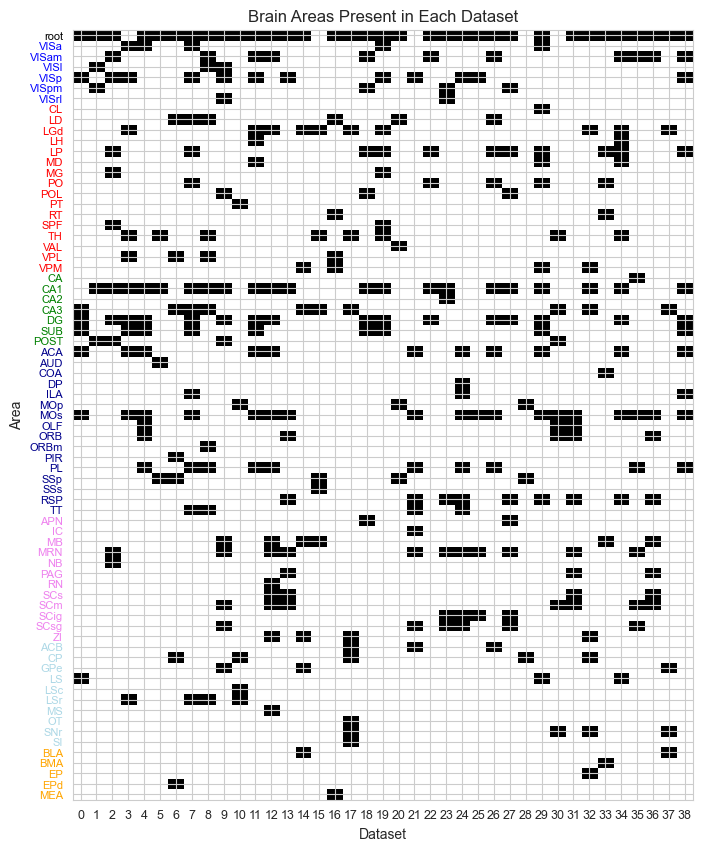

In [5]:
# Function to plot brain areas present in each dataset
def plot_brain_areas(data):
    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                    ]

    # Assign Each Area an Index
    area_to_index = dict(root=0)
    counter = 1
    for group in brain_groups:
        for area in group:
            area_to_index[area] = counter
            counter += 1

    # Determine Areas in Each Dataset
    areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
    for j, d in enumerate(data):
        for area in np.unique(d['brain_area']):
            i = area_to_index.get(area, -1)
            if i != -1:
                areas_by_dataset[i, j] = True

    # Visualize the Presence of Neurons in Different Regions Across Datasets
    plt.figure(figsize=(8, 10))
    plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

    # Label the Axes
    plt.xlabel("Dataset")
    plt.ylabel("Area")

    # Add Tick Labels
    yticklabels = ["root"]
    for group in brain_groups:
        yticklabels.extend(group)
    plt.yticks(np.arange(counter), yticklabels, fontsize=8)
    plt.xticks(np.arange(len(data)), fontsize=9)
 
    ytickobjs = plt.gca().get_yticklabels()
    ytickobjs[0].set_color("black")
    counter = 1
    for group, color in zip(brain_groups, region_colors):
        for area in group:
            ytickobjs[counter].set_color(color)
            counter += 1

    plt.title("Brain Areas Present in Each Dataset")
    plt.grid(True)
    plt.show()

# Plot brain areas present in each dataset
alldat = load_data(fnames)
plot_brain_areas(alldat)

In [6]:
brain_groups = {'visual_cortex':["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], 
                'thalamus': ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], 
                'hippocampal': ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  
                'non_visual_cortex': ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"], 
                'midbrain': ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], 
                'basal_ganglia': ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], 
                'cortical_subplate': ["BLA", "BMA", "EP", "EPd", "MEA"]}

In [7]:
brain_areas = []
for vals in brain_groups.values():
    brain_areas += vals
print(brain_areas)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


In [8]:
concat_df = process_data(alldat)

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz
C:\Python 

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\src\generate_psth_df.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\src\generate_psth_df.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\src\generate_psth_df.py:134: SettingWithCopyWarning: 
A value

In [9]:
concat_df.columns

Index(['brain_area', 'ap', 'dv', 'lr', 'neuron_id', 'response',
       'response_time', 'contrast_right', 'contrast_left', 'feedback_time',
       'feedback_type', 'gocue', 'prev_reward', 'reaction_time',
       'reaction_type', 'pupil_area', 'pupil_x', 'pupil_y', 'face', 'licks',
       'wheel', 'average_pupil_speed', 'trial_id', 'mouse_name', 'date_exp',
       'depths', 'site', 'probe', 'template_waveforms', 'waveform_duration',
       'peak_to_trough_duration', 'spks', 'contrast_pair', 'trial_outcome',
       'neuron_type'],
      dtype='object')

In [10]:
def str_to_array(string:str) -> np.ndarray:
    array = np.array(string.strip('[]').split()).astype(np.float64)
    return array


In [11]:
no_stim = (0.0,0.0)
no_stim_1 = (1.0,0.0)
no_stim_2 = (0.5,0.0)
no_stim_3 = (0.25,0.0)

stimulus_df = concat_df.query('~(contrast_pair == @no_stim_1) & ~(contrast_pair == @no_stim_2) & ~(contrast_pair == @no_stim_3) & ~(contrast_pair == @no_stim)')

In [12]:
no_stim_df = concat_df.query('(contrast_pair == @no_stim_1) | (contrast_pair == @no_stim_2) | (contrast_pair == @no_stim_3) | (contrast_pair == @no_stim)')

In [13]:
fig = plot_event_contrast_grid(stimulus_df,area='VISp')

NameError: name 'plot_event_contrast_grid' is not defined

{(0.25, 0.0): 'red', (0.5, 0.0): 'blue', (1.0, 0.0): 'red'}


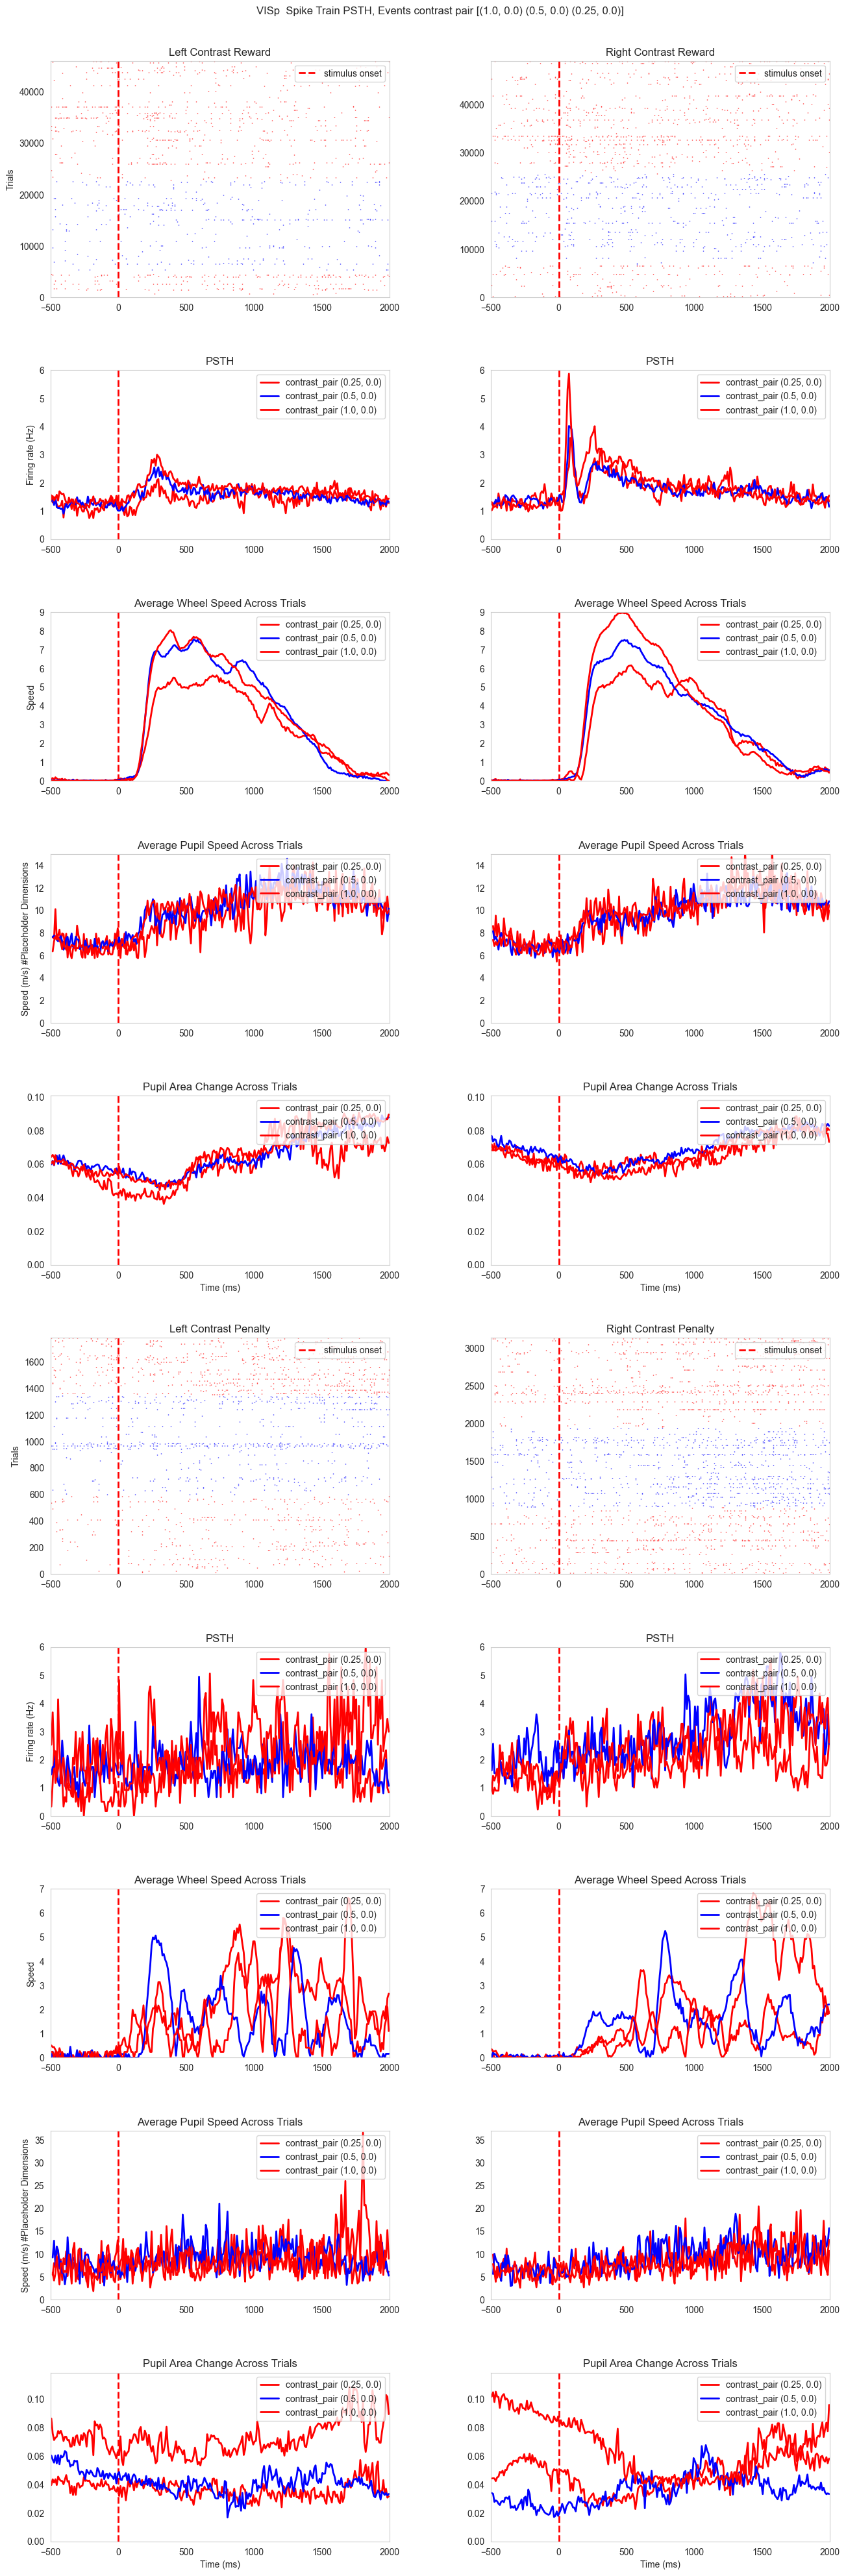

In [14]:
fig2 = plot_event_contrast_grid(no_stim_df,area='VISp')

In [15]:
# plt.ioff()  # Add this at the start of your code
# for region, subregions in brain_groups.items():
#     save_path = os.path.join(root,"figures",region)
#     print(save_path)
#     for subregion in subregions:
#         save_file = os.path.join(save_path,f'{subregion}')
#         if (os.path.isfile(save_file+"_stim_png")) and (os.path.isfile(save_file+"_nostim.png")):
#             print("pass")
#             continue
#         else:
#             print('processing')
#             try:
#                 stim_fig = plot_decision_trials_eventplot(data_df=stimulus_df,area=subregion,color_dict=combination_to_color)
#                 stim_fig.savefig(save_file+"_stim.png", dpi=300, bbox_inches='tight')
#                 no_stim_fig = plot_decision_trials_eventplot(data_df=no_stim_df,area=subregion,color_dict=combination_to_color)
#                 no_stim_fig.savefig(save_file+"_nostim.png", dpi=300, bbox_inches='tight')
#             except:
#                 continue
# plt.ion()


In [14]:
def calculate_psth(x):
    return np.mean(np.stack(x), axis=0)*100

In [15]:
def smooth_psth(psth, method='gaussian', **kwargs):
    """
    Smooth a Peri-Stimulus Time Histogram using various methods.

    Parameters:
    -----------
    psth : numpy.ndarray
        The raw PSTH data
    method : str
        Smoothing method ('gaussian', 'moving_average', or 'savgol')
    kwargs : dict
        Additional parameters specific to each method

    Returns:
    --------
    numpy.ndarray
        Smoothed PSTH data
    """

    if method == 'gaussian':
        # Gaussian smoothing
        sigma = kwargs.get('sigma', 2)
        return gaussian_filter(psth, sigma=sigma)

    elif method == 'moving_average':
        # Moving average smoothing
        window_size = kwargs.get('window_size', 5)
        kernel = np.ones(window_size) / window_size
        return np.convolve(psth, kernel, mode='same')

    elif method == 'savgol':
        # Savitzky-Golay filtering
        window_length = kwargs.get('window_length', 5)
        poly_order = kwargs.get('poly_order', 2)
        return savgol_filter(psth, window_length, poly_order)

    else:
        raise ValueError("Unknown smoothing method")

In [16]:
def latency_response_detection(x):

    psth = calculate_psth(x)

    gaussian_psth = smooth_psth(psth, 'gaussian', sigma=3)

    # baseline = x[:,:50]
    # #
    # # gaussian_psth = smooth_psth(psth, 'gaussian', sigma=2)
    # #
    # baseline_spike_count = np.mean(baseline, axis=1)
    # baseline_mean = np.mean(baseline_spike_count)*100
    # std = np.std(np.std(baseline, axis=1))
    # baseline_threshold = (baseline_mean + 2*std)



    baseline_mean = np.mean(psth[:50])
    std = np.std(psth[:50])
    baseline_threshold = baseline_mean + 2*std

    # Use gaussian for peak locations
    # Use raw for baseline and threshold calculations
    # Find start of threshold post-stimulus and

    # Find where signal crosses threshold between consecutive points
    sign_diff = np.diff(np.sign(gaussian_psth - baseline_mean))
    # Get indices where crossings occur
    # sign_diff will be:
    #  2 for crossing from below to above (decay)
    # -2 for crossing from above to below (rise)
    crossing_indices = np.where(sign_diff == 2)[0] #look for rise only

    peaks, properties = find_peaks(gaussian_psth,height= baseline_threshold,distance=int(100/10))

    lat = None
    peak_firing_rate = None

    peaks_after_50 = peaks[peaks>50]

    # if (peaks[peaks>50].size > 0) and (crossing_indices[crossing_indices>50].size > 0):
    if peaks_after_50.size > 0:

        first_peak = peaks_after_50[0]
        half_height = baseline_mean + ((gaussian_psth[first_peak] - baseline_mean)/2)
        lat_sign_diff = np.diff(np.sign(gaussian_psth[50:first_peak] - half_height))
        lat_cross = np.where(lat_sign_diff == 2)[0]

        if lat_cross.size == 0:
            lat = lat
            peak_firing_rate = peak_firing_rate
        else:
            lat = lat_cross[0]
            if std == 0:
                peak_firing_rate = gaussian_psth[first_peak] - baseline_mean  # Absolute difference
            else:
                peak_firing_rate = (gaussian_psth[first_peak] - baseline_mean) / std

    else:
        lat = lat
        peak_firing_rate = peak_firing_rate

    return lat, peak_firing_rate

In [17]:
exp_df = concat_df.groupby(['brain_area', 'trial_outcome', 'contrast_pair','contrast_right']).agg({
    'spks': [
        ('stack', lambda x: np.stack(x)),
        ('psth', lambda x: calculate_psth(np.stack(x))*10),
        ('latency_response', lambda x: latency_response_detection(np.stack(x))[0]),
        ('peak_firing_rate', lambda x: latency_response_detection(np.stack(x))[1]),
    ],
    'neuron_id':[
        ('neuron_count', lambda x: len(np.unique(np.stack(x))))
    ]
})


In [18]:
exp_df= exp_df.reset_index()
if isinstance(exp_df.columns, pd.MultiIndex):
    exp_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in exp_df.columns]

In [19]:
exp_df = exp_df.dropna().query('spks_latency_response != 0')

In [20]:
def test_latency_response_detection(x):

    baseline = x[:,:50]
    #
    # gaussian_psth = smooth_psth(psth, 'gaussian', sigma=2)
    #
    baseline_spike_count = np.mean(baseline, axis=1)
    baseline_mean_ = np.mean(baseline_spike_count)*100
    std_ = np.std(np.std(baseline, axis=1))
    baseline_threshold_ = (baseline_mean_ + 2*std_)

    print("spike_count", baseline_spike_count.shape)
    print("baseline_mean_", baseline_mean_)
    print("std_", std_)
    print("baseline_threshold_", baseline_threshold_)

    psth = calculate_psth(x)

    gaussian_psth = smooth_psth(psth, 'gaussian', sigma=3)

    baseline_mean = np.mean(psth[:50])
    std = np.std(psth[:50])
    baseline_threshold = baseline_mean + 2*std

    print("baseline_mean", baseline_mean)
    print("std", std)
    print("baseline_threshold", baseline_threshold)

    # Use gaussian for peak locations
    # Use raw for baseline and threshold calculations
    # Find start of threshold post-stimulus and

    # Find where signal crosses threshold between consecutive points
    sign_diff = np.diff(np.sign(gaussian_psth - baseline_mean))
    # Get indices where crossings occur
    # sign_diff will be:
    #  2 for crossing from below to above (decay)
    # -2 for crossing from above to below (rise)
    crossing_indices = np.where(sign_diff == 2)[0] #look for rise only

    peaks, properties = find_peaks(gaussian_psth,height= baseline_threshold,distance=int(100/10))

    lat = None
    peak_firing_rate = None
    half_height = None

    peaks_after_50 = peaks[peaks>50]

    # if (peaks[peaks>50].size > 0) and (crossing_indices[crossing_indices>50].size > 0):
    if peaks_after_50.size > 0:
        # first_rise = crossing_indices[np.where(np.abs(crossing_indices-50)==np.min(np.abs(crossing_indices-50)))[0]]
        first_peak = peaks_after_50[0]
        print("first_peak:",first_peak)
        # print("first_rise:",first_rise)
        half_height = baseline_mean + ((gaussian_psth[first_peak] - baseline_mean)/2)
        print("half_height:",half_height)
        lat_sign_diff = np.diff(np.sign(gaussian_psth[50:first_peak] - half_height))
        lat_cross = np.where(lat_sign_diff == 2)[0]
        print('lat_cross:',lat_cross)
        # print("lat_cross_first_rise:",lat_cross > first_rise)
        print("lat_cross_first_peak:",lat_cross < first_peak)
        # lat_cross_mask = np.logical_and(lat_cross > first_rise, lat_cross < first_peak)
        # print("lat_cross_mask:",lat_cross_mask)
        # print(np.all(~lat_cross_mask))
        # print(np.any(lat_cross_mask))
        # print("lat_cross_mask_bool:",(np.all(~lat_cross_mask)) or (np.any(lat_cross_mask)))
        if lat_cross.size == 0:
            lat = 0
            peak_firing_rate = 0
        else:
            lat = lat_cross[0]
            peak_firing_rate = (gaussian_psth[first_peak]-baseline_mean)/std
        print("peak_firing_rate:",peak_firing_rate)
        print("lat_cross:", lat_cross)
    else:
        lat = 0
        peak_firing_rate = 0
        first_peak = 0
    print("peak_firing_rate:",peak_firing_rate)
    print("lat_cross:", lat)
    print('='*50)

    return gaussian_psth, baseline_mean , baseline_threshold, baseline_mean_, baseline_threshold_, crossing_indices, peaks, half_height, lat, first_peak
    # return gaussian_psth, baseline_mean , baseline_threshold

In [21]:
# index = 7
# # test_psth = test_df[(test_df['contrast_pair']==(0.25,0.0)) & (test_df['trial_outcome']=='left_penalty')].iloc[:]
# # test_psth = np.array(test_df[(test_df['contrast_pair']==(1.0,0.0)) & (test_df['trial_outcome'] == "right_reward")]['spks_psth'].iloc[18])
# spike_train = contralat_1_0_df['spks_stack'].iloc[index]
# test_psth = np.array(contralat_1_0_df['spks_psth'].iloc[index])
# print(contralat_1_0_df['brain_area'].iloc[index])
# g,bm,bt, bm_, bt_, ci,pks,half,lat,fp =test_latency_response_detection(spike_train)
#
#
# time_bins = np.arange(-500  , 2000, 10)
# plt.figure(figsize=(12, 6))
# plt.plot(time_bins, calculate_psth(spike_train), 'gray', alpha=0.5, label='Original PSTH')
# plt.plot(time_bins, g, 'k', label='Smoothed PSTH')
# # plt.plot(time_bins, bm*np.ones(time_bins.shape), 'g--', label='Baseline Mean')
# plt.plot(time_bins, bt*np.ones(time_bins.shape), 'r--', label='Baseline Threshold', linewidth=2),
# plt.plot(time_bins, bm_*np.ones(time_bins.shape), 'g--', label='Baseline Mean Method 2', alpha=0.5)
# plt.plot(time_bins, bt_*np.ones(time_bins.shape), 'r--', label='Baseline Threshold Method 2', linewidth=2, alpha=0.5),
# plt.plot(time_bins[ci], g[ci], 'x', label='Crossing Indices')
# plt.plot(time_bins[pks], g[pks], 'r^', label='Peaks')
# plt.plot(time_bins, half*np.ones(time_bins.shape), 'k--', label='Half Height')
# # plt.plot(time_bins, g[fp]*np.ones(time_bins.shape), 'k--', label='First Peak')
# # plt.plot(time_bins, g[fr]*np.ones(time_bins.shape), color='orange',linestyle ='dashed', label='First Rise')
# # plt.plot(time_bins, rmt,'orange', label='Rolling Median Threshold')
# plt.plot(time_bins[50+lat],g[50+lat], 'b^', label='Latency Response')
# plt.xticks(np.arange(-500,2000,10))
#
#
# # # Highlight detected response periods
# # response_times = time_bins[results['response_bins']]
# # response_values = results['smoothed_psth'][results['response_bins']]
# # plt.plot(response_times, response_values, 'r', linewidth=2, label='Detected response')
#
# plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
# plt.xlabel('Time (ms)')
# plt.ylabel('Firing rate (Hz)')
# plt.legend()
# plt.title('PSTH Response Detection')
# plt.grid(True, alpha=0.3)
#
# plt.show()

In [303]:
def plot_psth_response_rank(df, figure_title):
    df = df.query('brain_area != "root"')

    print(df.trial_outcome.unique())
    dfs = []
    unique_pairs = [(1.0,0.0),(1.0,0.5),(1.0,0.25)]
    unique_outcomes = ['right_reward','left_reward']
    dfs = [df.query('contrast_pair == @pair & trial_outcome == @outcome') for pair in unique_pairs for outcome in unique_outcomes]

    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']

    brain_groups = [
        ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
        ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
        ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampus
        ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
        ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
        ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
        ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
    ]

    # Create region-to-color dictionary
    region_color_dict = dict(zip(regions, region_colors))
    brain_region_color_dict = {subregion: region_color_dict[region] for region, group in zip(regions, brain_groups) for subregion in group}

    # Create figure with more compact layout
    fig = plt.figure(figsize=(10, 12))  # Reduced figure size

    # Make grid more compact by adjusting width ratios
    grid_widths = [0.1, 0.5, 0.1]  # Reduced width for labels and latency
    gs = plt.GridSpec(2, 9, width_ratios=grid_widths * 3, wspace=0.0, hspace=0.15)  # Added wspace and hspace to reduce spacing

    im_list = []  # Store imshow plots for colorbar

    for i,trial_df in enumerate(dfs):
        data_df = trial_df.sort_values('spks_latency_response')
        data = np.stack(data_df.spks_psth.values)[:, 50:]
        response_latencies = np.stack(data_df.spks_latency_response.values)
        brain_areas = np.stack(data_df.brain_area.values)
        neuron_count = data_df.neuron_id_neuron_count.values

        column,row = divmod(i,2)
        label_column = column*3

        data_column = label_column + 1
        latency_column = label_column + 2
        title = "Contralateral" if trial_df.trial_outcome.unique()[0]=='right_reward' else 'Ipsilateral'

        # Brain region labels - more compact
        ax_labels = plt.subplot(gs[row, label_column])
        ax_labels.set_xlim(0, 1)
        ax_labels.set_ylim(0, len(brain_areas))

        # Use smaller font size for brain area labels
        for j, area in enumerate(brain_areas):
            ax_labels.text(0.9, len(brain_areas) - j - 0.5, area, ha='right', va='center',
                          color=brain_region_color_dict[area], fontsize=7)  # Reduced font size

        ax_labels.axis('off')

        # Activity plot
        ax_data = plt.subplot(gs[row, data_column])
        imshow_data = (data / np.mean(data, axis=1).reshape(data.shape[0], 1))
        im = ax_data.imshow(imshow_data[:,:30], aspect='auto', cmap='inferno')
        im_list.append(im)

        # More compact tick labels
        num_time_bins = imshow_data[:,:30].shape[1]
        ax_data.set_xticks(np.linspace(0, num_time_bins, 4))  # Reduced number of ticks
        ax_data.set_xticklabels(np.linspace(0, 300, 4).astype(int), fontsize=8)  # Smaller font

        ax_data.set_xlim(0, num_time_bins)
        ax_data.set_xlabel('Time from stimulus (ms)', fontsize=8)  # Smaller font
        ax_data.set_yticks([])
        ax_data.set_title(f'{title} {trial_df.contrast_pair.unique()[0]}', fontsize=9)  # Smaller title
        ax_data.grid(False)

        # Latency as text instead of bar plot
        ax_latency = plt.subplot(gs[row, latency_column])
        ax_latency.set_xlim(0, 1)
        ax_latency.set_ylim(0, len(brain_areas))

        # Display latency values as text
        for j, latency in enumerate(response_latencies):
            # Round to integer and display as text
            ax_latency.text(0.5, len(brain_areas) - j - 0.5, f"{int(latency*10)}",
                           ha='right', va='center', fontsize=6)
        if latency_column == 8:
            ax_latency.set_title('Latency(ms)', fontsize=9, pad=8)
        ax_latency.axis('off')  # Turn off axis

        # # Only show x-axis labels for bottom row plots
        # if row == 0:
        #     ax_data.set_xticklabels([])
        #     ax_data.set_xlabel('Time(ms)', fontsize=8)

    # Add a more compact colorbar
    cbar_ax = fig.add_axes([0.9, 0.6, 0.01, 0.2])  # Adjusted position
    cbar = fig.colorbar(im_list[-1], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Normalized Firing Rate', fontsize=8)  # Shorter label, smaller font
    cbar.ax.tick_params(labelsize=7)  # Smaller colorbar ticks

    # Set a more compact title
    fig.suptitle(figure_title, fontsize=12, y=0.98)  # Reduced fontsize and moved up

    # # Adjust the overall layout to be tighter
    # plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to account for title

    # plt.show()

['left_penalty' 'left_reward' 'nogo' 'right_penalty' 'right_reward']


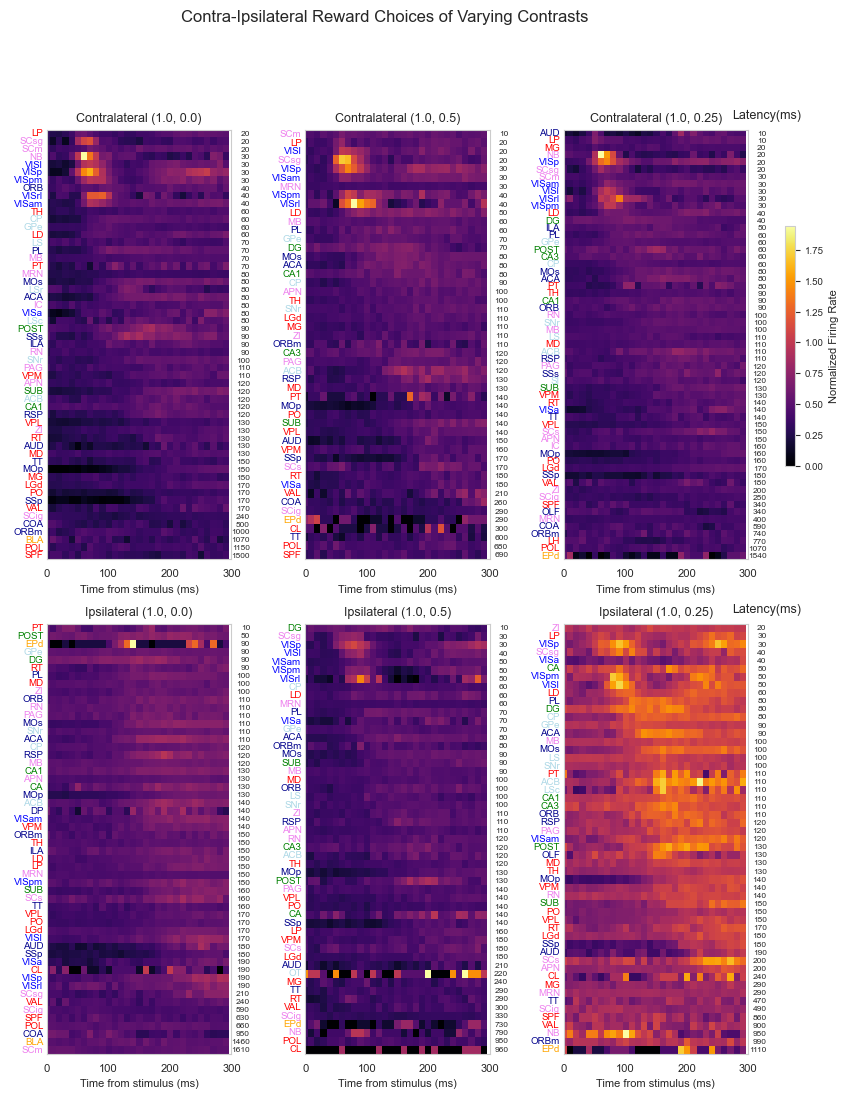

In [304]:
stim_1 = (1.0,0.0)
stim_2 = (1.0,0.5)
stim_3 = (1.0,0.25)

plot_psth_response_rank(exp_df,"Contra-Ipsilateral Reward Choices of Varying Contrasts")